In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.coordinates import SkyCoord
import astropy.units as u

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme() # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#5F6372', '#79A8A4', '#B2AD8F', '#92A186', '#AD8082']
blue = '#5F6372'
turqoise = '#79A8A4'
light_green = '#B2AD8F'
green = '#92A186'
pink = '#AD8082'
muted_colors = sns.set_palette(sns.color_palette(colors))

# configuring fonts for plotting
font = FontProperties()
font.set_family('avenir')
font.set_name('Big Caslon')
font.set_style('normal')
font.set_size('xx-large')


%matplotlib inline  

In [3]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
sys.path.insert(0,'../src/')
from BE_plotting import*
#from RR_lyrae_params import*
from blazhko_analysis import*

## Importing data

The first step is to import the `LINEAR` and `ZTF` data, as well as the data calculated in the previous notebook.

In [4]:
#| code-fold: false
# DATA
dataLINEAR = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library
end = 'FINAL_complete'

# DATA from previous notebook
lc_analysis = pd.read_csv('../outputs/LC_ANALYSIS_FINAL_complete.csv')
lc_select = pd.read_csv('../outputs/LC_ANALYSIS_complete_selectabove250.csv')
periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

In [5]:
lc_select.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,LCtype,IndicatorType,ChiType,BE_score
0,872620,0.549247,0.549248,0.5492,1.0000,282,0.079112,1.1,1.0,0.206811,...,1.8303,103.6269,0.0136,7.6183,0.22,0.00000,1,NaN,NaN,NaN
1,2041979,0.653694,0.653639,0.6537,0.9999,276,0.134647,1.5,1.2,0.137441,...,1.5347,207.4689,0.0144,9.8341,0.30,0.00008,1,NaN,NaN,NaN
2,2044369,0.534950,0.534950,0.5350,1.0000,253,0.095777,0.8,0.8,0.308125,...,1.8723,332.7787,0.0266,9.3489,0.15,0.00000,2,NaN,NaN,NaN
3,2227132,0.642661,0.642661,0.6427,1.0000,260,0.039765,2.2,1.0,0.117412,...,1.5916,28.1136,0.0191,10.9645,0.25,0.00000,2,NaN,NaN,NaN
4,2280940,0.562372,0.562374,0.5624,1.0000,310,0.120769,1.4,1.1,0.177601,...,1.7817,288.6003,0.0118,10.4442,0.23,0.00000,2,NaN,NaN,NaN


In [6]:
lc_analysis.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,LCtype,IndicatorType,ChiType,BE_score
0,50402,0.643303,0.643294,0.6433,1.0000,284,0.105976,0.6,0.7,0.107611,...,1.9160,295.8580,0.0149,2.2053,0.10,0.00001,1,NaN,NaN,NaN
1,62892,0.530776,0.530785,0.5308,1.0000,276,0.108535,1.1,0.9,0.131104,...,1.9434,16.8265,0.0291,4.9825,0.20,0.00002,1,NaN,NaN,NaN
2,136668,0.532923,0.532929,0.5329,1.0000,310,0.123066,1.6,1.1,0.151065,...,1.9396,15.8403,0.0801,8.7778,0.15,0.00001,1,NaN,NaN,NaN
3,141414,0.335690,0.335669,0.3357,0.9999,278,0.119125,0.6,0.8,0.180636,...,1.4928,306.2787,0.0211,4.7280,0.10,0.00006,1,NaN,NaN,NaN
4,142794,0.470787,0.470802,0.4708,1.0000,270,0.095003,1.8,1.0,0.116360,...,2.1851,16.3626,0.0286,6.0733,0.00,0.00003,2,NaN,NaN,NaN


### Plotting a light curve as an example

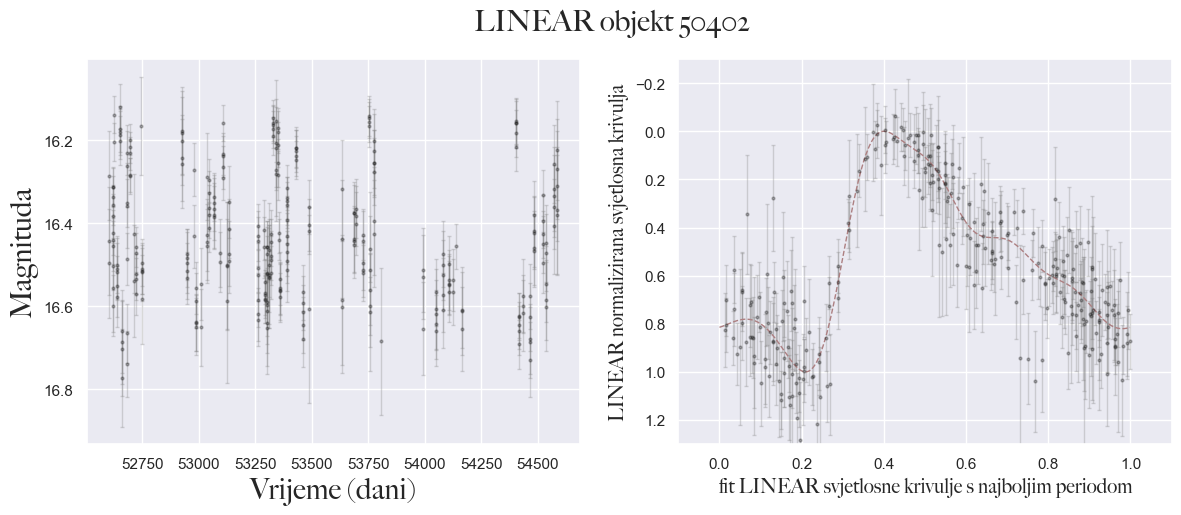

In [7]:
order = 0
LiNeAr_ids = lc_analysis['LINEAR id'].to_numpy()
total_num = len(lc_analysis['LINEAR id'].to_numpy())
Lid = LiNeAr_ids[order]
lc_data_order = dataLINEAR.get_light_curve(Lid)
time, mag, magerr = lc_data_order.T
for n, j in enumerate(fits):
    if j[0]==Lid:
        break

L1 = fits[n][1][0]

fig, ax = plt.subplots(1,2, figsize=(14,5))   
#fig.suptitle('STAR '+str(order+1)+' from '+str(total_num), fontsize=30, fontproperties=font)
fig.set_facecolor('white')

#--------
ax[0].errorbar(time, mag, magerr, fmt='.k', ecolor='gray',lw=1, ms=4, capsize=1.5,alpha=0.3)
ax[0].set_xlabel('Vrijeme (dani)',fontproperties=font)
ax[0].set_ylabel('Magnituda', fontproperties=font)
fig.suptitle('LINEAR objekt {0}'.format(Lid), fontproperties=font)
ax[0].invert_yaxis()

# -----

ax[1].set_xlabel('fit LINEAR svjetlosne krivulje s najboljim periodom', fontproperties=font, fontsize=14)
ax[1].set_ylabel('LINEAR normalizirana svjetlosna krivulja', fontproperties=font, fontsize=14)
ax[1].set_xlim(-0.1, 1.1)
ax[1].set_ylim(1.3, -0.3)
# data
xx, yy, zz = sort3arr(L1['dataPhasedTime'], L1['dataTemplate'], L1['dataTemplateErr'])
ax[1].errorbar(xx, yy, zz, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
# fit for Plinear
ax[1].plot(L1['modelPhaseGrid'], L1['modTemplate'], pink, markeredgecolor=pink, lw=1, fillstyle='top', linestyle='dashed')

plt.savefig("../images/primjer_svkrivulje_sve.png", dpi=600)

In [8]:
lc_analysis.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,LCtype,IndicatorType,ChiType,BE_score
0,50402,0.643303,0.643294,0.6433,1.0000,284,0.105976,0.6,0.7,0.107611,...,1.9160,295.8580,0.0149,2.2053,0.10,0.00001,1,NaN,NaN,NaN
1,62892,0.530776,0.530785,0.5308,1.0000,276,0.108535,1.1,0.9,0.131104,...,1.9434,16.8265,0.0291,4.9825,0.20,0.00002,1,NaN,NaN,NaN
2,136668,0.532923,0.532929,0.5329,1.0000,310,0.123066,1.6,1.1,0.151065,...,1.9396,15.8403,0.0801,8.7778,0.15,0.00001,1,NaN,NaN,NaN
3,141414,0.335690,0.335669,0.3357,0.9999,278,0.119125,0.6,0.8,0.180636,...,1.4928,306.2787,0.0211,4.7280,0.10,0.00006,1,NaN,NaN,NaN
4,142794,0.470787,0.470802,0.4708,1.0000,270,0.095003,1.8,1.0,0.116360,...,2.1851,16.3626,0.0286,6.0733,0.00,0.00003,2,NaN,NaN,NaN


NameError: name 'L2' is not defined

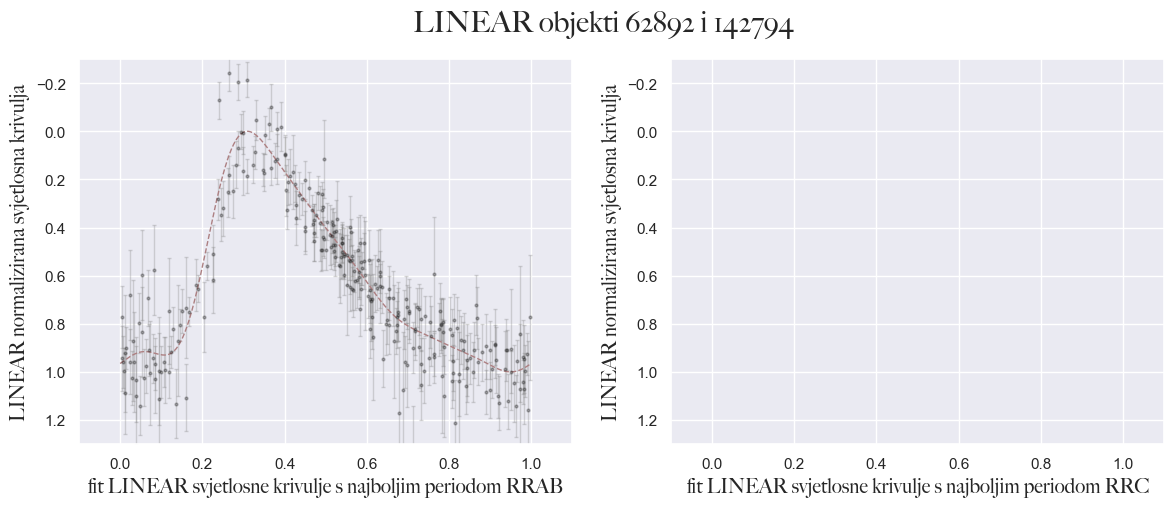

In [9]:
order1 = 1
order2 = 4
LiNeAr_ids = lc_analysis['LINEAR id'].to_numpy()
total_num = len(lc_analysis['LINEAR id'].to_numpy())
Lid1 = LiNeAr_ids[order1]
Lid2 = LiNeAr_ids[order2]
for n, j in enumerate(fits):
    if j[0]==Lid1:
        L1 = fits[n][1][0]
        break
    if j[0]==Lid2:
        L2 = fits[n][1][0]
        break

fig, ax = plt.subplots(1,2, figsize=(14,5)) 
fig.suptitle('LINEAR objekti {0} i {1}'.format(Lid1, Lid2), fontproperties=font)
fig.set_facecolor('white')

#--------
ax[0].set_xlabel('fit LINEAR svjetlosne krivulje s najboljim periodom RRAB', fontproperties=font, fontsize=14)
ax[0].set_ylabel('LINEAR normalizirana svjetlosna krivulja', fontproperties=font, fontsize=14)
ax[0].set_xlim(-0.1, 1.1)
ax[0].set_ylim(1.3, -0.3)
# data
xx, yy, zz = sort3arr(L1['dataPhasedTime'], L1['dataTemplate'], L1['dataTemplateErr'])
ax[0].errorbar(xx, yy, zz, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
# ft for Plinear
ax[0].plot(L1['modelPhaseGrid'], L1['modTemplate'], pink, markeredgecolor=pink, lw=1, fillstyle='top', linestyle='dashed')

# -----
ax[1].set_xlabel('fit LINEAR svjetlosne krivulje s najboljim periodom RRC', fontproperties=font, fontsize=14)
ax[1].set_ylabel('LINEAR normalizirana svjetlosna krivulja', fontproperties=font, fontsize=14)
ax[1].set_xlim(-0.1, 1.1)
ax[1].set_ylim(1.3, -0.3)
# data
xx, yy, zz = sort3arr(L2['dataPhasedTime'], L2['dataTemplate'], L2['dataTemplateErr'])
ax[1].errorbar(xx, yy, zz, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
# fit for Plinear
ax[1].plot(L2['modelPhaseGrid'], L2['modTemplate'], pink, markeredgecolor=pink, lw=1, fillstyle='top', linestyle='dashed')

plt.savefig("../images/rrabirrcprimjer.png", dpi=600)

# Determination of BE candidates

(write up entire explanation of the algorithm)

In [10]:
blazhko_can = pd.DataFrame(())
blazhko_can = blazhko_determine(lc_analysis, blazhko_can)
end = 'final'
blazhko_can.to_csv("../outputs/blazhko_can"+end+".csv", index=False)

In [11]:
blazhko_can.shape

(173, 40)

In [12]:
blazhko_can_select = pd.DataFrame(())
blazhko_can_select = blazhko_determine(lc_select, blazhko_can_select)
end = 'final'
blazhko_can.to_csv("../outputs/blazhko_can_select"+end+".csv", index=False)

In [13]:
blazhko_can_select.shape

(3, 40)

# Determining vallidity of BE candidates

In order to make visual interpretation easier and more robust, we are dividing our BE candidates into smaller tables. The categories are:
- LINEAR periodogram parameter satisfied
- ZTF periodogram parameter satisfied
- Chi2 parameter satisfied
    - ZTF Chi2 parameter
    - LINEAR Chi2 parameter

The last three are based on the `ChiType` for determining LINEAR or ZTF parameter satisfaction. The periodogram parameter is determined by the `IndicatorType` column.

# Visual inspection of every category

In [14]:
BE_candidates_ztf_per = category_analysis(blazhko_can, 'IndicatorType', 'Z', fits, periodogr, ztf_data, dataLINEAR, 'ztf_periodogram')

This dataset has 99 stars.


In [ ]:
BE_candidates_linear_per = category_analysis(blazhko_can, 'IndicatorType', 'L', fits, periodogr, ztf_data, dataLINEAR, 'linear_periodogram')

In [ ]:
BE_candidates_ztf_chi = category_analysis(blazhko_can, 'ChiType', 'Z', fits, periodogr, ztf_data, dataLINEAR, 'ztf_chi')

In [ ]:
BE_candidates_linear_chi = category_analysis(blazhko_can, 'ChiType', 'L', fits, periodogr, ztf_data, dataLINEAR, 'ztf_chi')